# Full Trajectory Estimation

In [1]:
import os
import pickle
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from glob import glob
from time import time
from scipy.stats import linregress
from pyomo.environ import *
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from lib import misc, utils, app
from lib.calib import triangulate_points_fisheye, project_points_fisheye

plt.style.use(os.path.join('..', 'configs', 'mplstyle.yaml'))

%load_ext autoreload
%autoreload 2

ROOT_DATA_DIR = os.path.join("/Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main","data")

# Reconstruction params

In [2]:
DATA_DIR = os.path.join(ROOT_DATA_DIR, "2021_10_07", "Baboon1", "walk")

start_frame = 23540
end_frame = 23640

# DLC p_cutoff - any points with likelihood < dlc_thresh are not trusted in optimisation
dlc_thresh = 0.5 # change this only if the optimisation result is unsatisfactory

print("Set frame range")

Set frame range


# Robust Cost Function

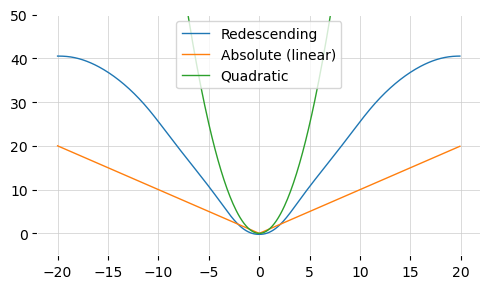

In [3]:
# PLOT OF REDESCENDING, ABSOLUTE AND QUADRATIC COST FUNCTIONS
# we use a redescending cost to stop outliers affecting the optimisation negatively
redesc_a = 3
redesc_b = 10
redesc_c = 20

#Plot
r_x = np.arange(-20,20, 1e-1)
r_y1 = [misc.redescending_loss(i, redesc_a, redesc_b, redesc_c) for i in r_x]
r_y2 = abs(r_x)
r_y3 = r_x**2
plt.figure(figsize=(5,3))
plt.plot(r_x,r_y1, label="Redescending")
plt.plot(r_x,r_y2, label="Absolute (linear)")
plt.plot(r_x,r_y3, label="Quadratic")
ax = plt.gca()
ax.set_ylim((-5, 50))
ax.legend()

# Optimisation

In [4]:
t0 = time()

assert os.path.exists(DATA_DIR)
OUT_DIR = os.path.join(DATA_DIR, 'fte')
DLC_DIR = os.path.join(DATA_DIR, 'dlc')
assert os.path.exists(DLC_DIR)
os.makedirs(OUT_DIR, exist_ok=True)

app.start_logging(os.path.join(OUT_DIR, 'fte.log'))

# load video info
res, fps, tot_frames, _ = app.get_vid_info(DATA_DIR) # path to original videos
assert end_frame <= tot_frames, f'end_frame must be less than or equal to {tot_frames}'

print("Load video info")

start_frame -= 1; # 0 based indexing
assert start_frame >= 0
N = end_frame-start_frame
Ts = 1.0/fps # timestep

## ========= POSE FUNCTIONS ========
#SYMBOLIC ROTATION MATRIX FUNCTIONS
def rot_x(x):
    c = sp.cos(x)
    s = sp.sin(x)
    return sp.Matrix([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def rot_y(y):
    c = sp.cos(y)
    s = sp.sin(y)
    return sp.Matrix([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def rot_z(z):
    c = sp.cos(z)
    s = sp.sin(z)
    return sp.Matrix([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

L = 18  # number of joints in the baboon model

# defines arrays of angles, velocities and accelerations
phi     = [sp.symbols(f"\\phi_{{{l}}}")   for l in range(L)]
theta   = [sp.symbols(f"\\theta_{{{l}}}") for l in range(L)]
psi     = [sp.symbols(f"\\psi_{{{l}}}")   for l in range(L)]


print("Pose function")
#ROTATIONS
RI_0 = rot_z(psi[0]) @ rot_x(phi[0]) @ rot_y(theta[0]) # head
R0_I = RI_0.T
RI_1 = rot_z(psi[1]) @ rot_x(phi[1]) @ rot_y(theta[1]) @ RI_0 # neck
R1_I = RI_1.T
RI_2 = rot_y(theta[2]) @ RI_1 # front torso
R2_I = RI_2.T
RI_3 = rot_z(psi[3])@ rot_y(theta[3]) @ RI_2 # spine 1
R3_I = RI_3.T
RI_4 = rot_z(psi[4]) @ rot_y(theta[4]) @ RI_3 # spine 2
R4_I = RI_4.T
RI_5 = rot_z(psi[5]) @ rot_y(theta[5]) @ RI_4 # spine 3
R5_I = RI_5.T
RI_6 = rot_z(psi[6]) @ rot_y(theta[6]) @ RI_5 # back torso
R6_I = RI_6.T
RI_7 = rot_z(psi[7]) @ rot_y(theta[7]) @ RI_6 # tail base
R7_I = RI_7.T
RI_8 = rot_z(psi[8]) @ rot_y(theta[8]) @ RI_7 # tail 1
R8_I = RI_8.T
RI_9 = rot_z(psi[9]) @ rot_y(theta[9]) @ RI_8 # tail 2
R9_I = RI_9.T
RI_10 = rot_y(theta[10]) @ RI_2 # left shoulder
R10_I = RI_10.T
RI_11 = rot_y(theta[11]) @ RI_10 # left elbow
R11_I = RI_11.T
RI_12 = rot_y(theta[12]) @ RI_2 # right shoulder
R12_I = RI_12.T
RI_13 = rot_y(theta[13]) @ RI_12 # right elbow
R13_I = RI_13.T
RI_14 = rot_y(theta[14]) @ RI_6 # left hip
R14_I = RI_14.T
RI_15 = rot_y(theta[15]) @ RI_14 # left knee
R15_I = RI_15.T
RI_16 = rot_y(theta[16]) @ RI_6 # right hip
R16_I = RI_16.T
RI_17 = rot_y(theta[17]) @ RI_16 # right knee
R17_I = RI_17.T


print("Rotations")
# defines the position, velocities and accelerations in the inertial frame
x,   y,   z   = sp.symbols("x y z")
dx,  dy,  dz  = sp.symbols("\\dot{x} \\dot{y} \\dot{z}")
ddx, ddy, ddz = sp.symbols("\\ddot{x} \\ddot{y} \\ddot{z}")
# x_l, y_l, z_l = sp.symbols("x_l y_l z_l") # exclude lure for now


# SYMBOLIC baboon POSE POSITIONS
p_head          = sp.Matrix([x, y, z])

p_left_eye      = p_head         + R0_I  @ sp.Matrix([0, 0.021, 0])
p_right_eye     = p_head         + R0_I  @ sp.Matrix([0, -0.021, 0])
p_snout         = p_head         + R0_I  @ sp.Matrix([0.002, 0, -0.069])

p_neck_base     = p_head         + R1_I  @ sp.Matrix([-0.129, 0, -0.024])
p_spine_1       = p_neck_base    + R2_I  @ sp.Matrix([-0.05, 0, 0.05])
p_spine_2       = p_spine_1      + R3_I  @ sp.Matrix([-0.096, 0, -0.05])
p_spine_3       = p_spine_2      + R4_I  @ sp.Matrix([-0.102, 0, -0.009])
p_spine_4       = p_spine_3      + R5_I  @ sp.Matrix([-0.104, 0, -0.037])

p_tail_base     = p_spine_4      + R6_I  @ sp.Matrix([-0.057, 0, -0.019])
p_tail_1        = p_tail_base    + R7_I  @ sp.Matrix([-0.067, 0, 0.038])
p_tail_2        = p_tail_1       + R8_I  @ sp.Matrix([-0.024, 0, -0.104])
p_tail_end      = p_tail_2       + R9_I  @ sp.Matrix([0.021, 0, -0.135])

p_left_shoulder = p_neck_base    + R2_I  @ sp.Matrix([-0.018, 0.009, -0.115])
p_left_elbow    = p_left_shoulder+ R10_I @ sp.Matrix([-0.01, 0, -0.122])
p_left_wrist    = p_left_elbow   + R11_I @ sp.Matrix([0.051, 0, -0.176])

p_right_shoulder= p_neck_base    + R2_I  @ sp.Matrix([-0.018, -0.009, -0.115])
p_right_elbow   = p_right_shoulder+ R12_I@ sp.Matrix([-0.01, 0, -0.122])
p_right_wrist   = p_right_elbow   + R13_I@ sp.Matrix([0.051, 0, -0.176])

p_left_hip      = p_spine_4      + R6_I  @ sp.Matrix([-0.038, 0.008, -0.087])
p_left_knee     = p_left_hip     + R14_I @ sp.Matrix([0.054, 0, -0.115])
p_left_ankle    = p_left_knee    + R15_I @ sp.Matrix([-0.113, 0, -0.124])

p_right_hip     = p_spine_4      + R6_I  @ sp.Matrix([-0.038, -0.008, -0.087])
p_right_knee    = p_right_hip    + R16_I @ sp.Matrix([0.054, 0, -0.115])
p_right_ankle   = p_right_knee   + R17_I @ sp.Matrix([-0.113, 0, -0.124])

# print("p_head: \n",p_head)         

# print("p_left_eye: \n",p_left_eye)   
# print("p_right_eye: \n",p_right_eye)     
# print("p_snout: \n",p_snout)         

# print("p_neck_base: \n",p_neck_base)     
# print("p_spine_1: \n",p_spine_1)       
# print("p_spine_2: \n",p_spine_2)       
# print("p_spine_3: \n",p_spine_3)       
# print("p_spine_4: \n",p_spine_4)       

# print("p_tail_base: \n",p_tail_base)     
# print("p_tail_1: \n",p_tail_1)        
# print("p_tail_2: \n",p_tail_2)       
# print("p_tail_end: \n",p_tail_end)      

# print("p_left_shoulder: \n",p_left_shoulder) 
# print("p_left_elbow: \n",p_left_elbow)    
# print("p_left_wrist: \n",p_left_wrist)    

# print("p_right_shoulder: \n",p_right_shoulder)
# print("p_right_elbow: \n",p_right_elbow)   
# print("p_right_wrist: \n",p_right_wrist)  

# print("p_left_hip: \n",p_left_hip)      
# print("p_left_knee: \n",p_left_knee)     
#print("p_left_ankle: \n",p_left_ankle)    

#print("p_right_hip: \n",p_right_hip)     
#print("p_right_knee: \n",p_right_knee)    
#print("p_right_ankle: \n",p_right_ankle)   

# p_lure          = sp.Matrix([x_l, y_l, z_l])

# ========= LAMBDIFY SYMBOLIC FUNCTIONS ========
positions = sp.Matrix([
    p_left_eye.T, p_right_eye.T, p_snout.T,
    p_neck_base.T, p_spine_1.T, p_spine_2.T,
    p_spine_3.T, p_spine_4.T, p_tail_base.T,
    p_tail_1.T, p_tail_2.T, p_tail_end.T,
    p_left_shoulder.T, p_left_elbow.T, p_left_wrist.T,
    p_right_shoulder.T, p_right_elbow.T, p_right_wrist.T,
    p_left_hip.T, p_left_knee.T, p_left_ankle.T,
    p_right_hip.T, p_right_knee.T, p_right_ankle.T
    ])

print("Posisitions: ", len(positions))

func_map = {"sin":sin, "cos":cos, "ImmutableDenseMatrix":np.array} 
sym_list = [x, y, z,
            *phi, *theta, *psi 
           ]
print("sym_list")
pose_to_3d = sp.lambdify(sym_list, positions, modules=[func_map])

print("Pose to 3d ")

      
pos_funcs = []
for i in range(positions.shape[0]):
    lamb = sp.lambdify(sym_list, positions[i,:], modules=[func_map])
    pos_funcs.append(lamb)

    
print("Lambdify symbolic functions: ")

# ========= PROJECTION FUNCTIONS ========
def pt3d_to_2d(x, y, z, K, D, R, t):
    x_2d = x*R[0,0] + y*R[0,1] + z*R[0,2] + t.flatten()[0]
    y_2d = x*R[1,0] + y*R[1,1] + z*R[1,2] + t.flatten()[1]
    z_2d = x*R[2,0] + y*R[2,1] + z*R[2,2] + t.flatten()[2]
    #project onto camera plane
    a = x_2d/z_2d
    b = y_2d/z_2d
    #fisheye params
    r = (a**2 + b**2 +1e-12)**0.5 
    th = atan(r)
    #distortion
    th_D = th * (1 + D[0]*th**2 + D[1]*th**4 + D[2]*th**6 + D[3]*th**8)
    x_P = a*th_D/r
    y_P = b*th_D/r
    u = K[0,0]*x_P + K[0,2]
    v = K[1,1]*y_P + K[1,2]
    return u, v

def pt3d_to_x2d(x, y, z, K, D, R, t):
    u = pt3d_to_2d(x, y, z, K, D, R, t)[0]
    return u

def pt3d_to_y2d(x, y, z, K, D, R, t):
    v = pt3d_to_2d(x, y, z, K, D, R, t)[1]
    return v

print("Projection functions")

# ========= IMPORT CAMERA & SCENE PARAMS ========
K_arr, D_arr, R_arr, t_arr, cam_res, n_cams, scene_fpath = utils.find_scene_file(DATA_DIR)
D_arr = D_arr.reshape((-1,4))

print("Import camera")
# ========= IMPORT DATA ========
markers = misc.get_markers()

def get_meas_from_df(n, c, l, d):
    n_mask = points_2d_df["frame"]== n-1
    l_mask = points_2d_df["marker"]== markers[l-1]
    c_mask = points_2d_df["camera"]== c-1
    d_idx = {1:"x", 2:"y"}
    val = points_2d_df[n_mask & l_mask & c_mask]
    return val[d_idx[d]].values[0]

def get_likelihood_from_df(n, c, l):
    n_mask = points_2d_df["frame"]== n-1
    l_mask = points_2d_df["marker"]== markers[l-1]
    c_mask = points_2d_df["camera"]== c-1
    val = points_2d_df[n_mask & l_mask & c_mask]
    return val["likelihood"].values[0]

proj_funcs = [pt3d_to_x2d, pt3d_to_y2d]

R = 5 # measurement standard deviation

Q = [ # model parameters variance
    4, 7, 5, # x, y, z
    13, 32, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, #  phi_1, ... , phi_18
    9, 18, 43, 53, 53, 53, 53, 90, 118, 118, 247, 186, 194, 164, 295, 243, 334, 149, # theta_1, ... , theta_n
    26, 12, 0, 34, 34, 34, 34, 43, 51, 51, 0, 0, 0, 0, 0, 0, 0, 0 # psi_1, ... , psi_n
]
Q = np.array(Q, dtype=np.float64)**2

#===================================================
#                   Load in data
#===================================================
print("Loading data")

df_paths = sorted(glob(os.path.join(DLC_DIR, '*.h5')))

points_2d_df = utils.load_dlc_points_as_df(df_paths, verbose=False)
points_3d_df = utils.get_pairwise_3d_points_from_df(
    points_2d_df[points_2d_df['likelihood']>dlc_thresh],
    K_arr, D_arr, R_arr, t_arr,
    triangulate_points_fisheye
)


# estimate initial points
snout_pts = points_3d_df[points_3d_df["marker"]=="snout"][["frame", "x", "y", "z"]].values
x_slope, x_intercept, *_ = linregress(snout_pts[:,0], snout_pts[:,1])
y_slope, y_intercept, *_ = linregress(snout_pts[:,0], snout_pts[:,2])
z_slope, z_intercept, *_ = linregress(snout_pts[:,0], snout_pts[:,3])
frame_est = np.arange(end_frame)
x_est = frame_est*x_slope + x_intercept
y_est = frame_est*y_slope + y_intercept
z_est = frame_est*z_slope + z_intercept
psi_est = np.arctan2(y_slope, x_slope)


#===================================================
#                   Optimisation
#===================================================
print("\nStarted Optimisation")
m = ConcreteModel(name = "Baboon from measurements")
m.Ts = Ts

# ===== SETS =====
N = end_frame-start_frame # number of timesteps in trajectory
P = 3 + len(phi)+len(theta)+len(psi)# + 3  # number of pose parameters (x, y, z, phi_1..n, theta_1..n, psi_1..n, x_l, y_l, z_l)
L = len(pos_funcs) # number of dlc labels per frame
C = len(K_arr) # number of cameras
D2 = 2 # dimensionality of measurements
D3 = 3 # dimensionality of measurements

m.N = RangeSet(N)
m.P = RangeSet(P)
m.L = RangeSet(L)
m.C = RangeSet(C)
m.D2 = RangeSet(D2)
m.D3 = RangeSet(D3)

# ======= WEIGHTS =======
def init_meas_weights(model, n, c, l):
    likelihood = get_likelihood_from_df(n+start_frame, c, l)
    if likelihood > dlc_thresh:
        return 1/R
    else:
        return 0
m.meas_err_weight = Param(m.N, m.C, m.L, initialize=init_meas_weights, mutable=True)  # IndexError: index 0 is out of bounds for axis 0 with size 0 means that N is too large

def init_model_weights(m, p):
    if Q[p-1] != 0.0:
        return 1/Q[p-1]
    else:
        return 0
m.model_err_weight = Param(m.P, initialize=init_model_weights)

# ===== PARAMETERS =====
print("Initialising params & variables")

def init_measurements_df(m, n, c, l, d2):
    return get_meas_from_df(n+start_frame, c, l, d2)
m.meas = Param(m.N, m.C, m.L, m.D2, initialize=init_measurements_df)

# ===== VARIABLES =====
m.x = Var(m.N, m.P) #position
m.dx = Var(m.N, m.P) #velocity
m.ddx = Var(m.N, m.P) #acceleration
m.poses = Var(m.N, m.L, m.D3)
m.slack_model = Var(m.N, m.P)
m.slack_meas = Var(m.N, m.C, m.L, m.D2, initialize=0.0)

# ===== VARIABLES INITIALIZATION =====
init_x = np.zeros((N, P))
init_x[:,0] = x_est[start_frame: start_frame+N] #x # change this to [start_frame: end_frame]?
init_x[:,1] = y_est[start_frame: start_frame+N] #y
init_x[:,2] = z_est[start_frame: start_frame+N] #z
init_x[:,39] = psi_est # yaw = psi
init_dx = np.zeros((N, P))
init_ddx = np.zeros((N, P))
for n in m.N:
    for p in m.P:
        if n<len(init_x): #init using known values
            m.x[n,p].value = init_x[n-1,p-1]
            m.dx[n,p].value = init_dx[n-1,p-1]
            m.ddx[n,p].value = init_ddx[n-1,p-1]
        else: #init using last known value
            m.x[n,p].value = init_x[-1,p-1]
            m.dx[n,p].value = init_dx[-1,p-1]
            m.ddx[n,p].value = init_ddx[-1,p-1]
    #init pose
    var_list = [m.x[n,p].value for p in range(1, P+1)]
    for l in m.L:
        [pos] = pos_funcs[l-1](*var_list)
        for d3 in m.D3:
            m.poses[n,l,d3].value = pos[d3-1]

# ===== CONSTRAINTS =====
# 3D POSE
def pose_constraint(m,n,l,d3):
    #get 3d points
    var_list = [m.x[n,p] for p in range(1, P+1)]
    [pos] = pos_funcs[l-1](*var_list)
    return pos[d3-1] == m.poses[n,l,d3]

m.pose_constraint = Constraint(m.N, m.L, m.D3, rule=pose_constraint)

# INTEGRATION
print("Numerical integration")
def backwards_euler_pos(m,n,p): # position
    if n > 1:
#             return m.x[n,p] == m.x[n-1,p] + m.h*m.dx[n-1,p] + m.h**2 * m.ddx[n-1,p]/2
        return m.x[n,p] == m.x[n-1,p] + m.Ts*m.dx[n,p]

    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.P, rule = backwards_euler_pos)

def backwards_euler_vel(m,n,p): # velocity
    if n > 1:
        return m.dx[n,p] == m.dx[n-1,p] + m.Ts*m.ddx[n,p]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.P, rule = backwards_euler_vel)

# MODEL
def constant_acc(m, n, p):
    if n > 1:
        return m.ddx[n,p] == m.ddx[n-1,p] + m.slack_model[n,p]
    else:
        return Constraint.Skip 
m.constant_acc = Constraint(m.N, m.P, rule = constant_acc)

# MEASUREMENT 
def measurement_constraints(m, n, c, l, d2):
    #project
    K, D, R, t = K_arr[c-1], D_arr[c-1], R_arr[c-1], t_arr[c-1]
    x, y, z = m.poses[n,l,1], m.poses[n,l,2], m.poses[n,l,3]
    return proj_funcs[d2-1](x, y, z, K, D, R, t) - m.meas[n, c, l, d2] - m.slack_meas[n, c, l, d2] ==0
m.measurement = Constraint(m.N, m.C, m.L, m.D2, rule = measurement_constraints)

#===== POSE CONSTRAINTS (Note 1 based indexing for pyomo!!!!...@#^!@#&) =====
#Head
def head_phi_0(m,n):
    return abs(m.x[n,4]) <= np.pi/6
m.head_phi_0 = Constraint(m.N, rule=head_phi_0)
def head_theta_0(m,n):
    return abs(m.x[n,22]) <= np.pi/6
m.head_theta_0 = Constraint(m.N, rule=head_theta_0)

#Neck
def neck_phi_1(m,n):
    return abs(m.x[n,5]) <= np.pi/6
m.neck_phi_1 = Constraint(m.N, rule=neck_phi_1)
def neck_theta_1(m,n):
    return abs(m.x[n,22]) <= np.pi/6
m.neck_theta_1 = Constraint(m.N, rule=neck_theta_1)
def neck_psi_1(m,n):
    return abs(m.x[n,41]) <= np.pi/6
m.neck_psi_1 = Constraint(m.N, rule=neck_psi_1)

#Front torso
def front_torso_theta_2(m,n):
    return abs(m.x[n,24]) <= np.pi/6
m.front_torso_theta_2 = Constraint(m.N, rule=front_torso_theta_2)

#Spine 1
def spine_1_theta_3(m,n):
    return abs(m.x[n,25]) <= np.pi/6
m.spine_1_theta_3 = Constraint(m.N, rule=spine_1_theta_3)
def spine_1_phi_3(m,n):
    return abs(m.x[n,7]) <= np.pi/6
m.spine_1_phi_3 = Constraint(m.N, rule=spine_1_phi_3)
# def back_torso_psi_3(m,n):
#     return abs(m.x[n,35]) <= np.pi/6
# m.back_torso_psi_3 = Constraint(m.N, rule=back_torso_psi_3)

#Spine 2
def spine_2_theta_4(m,n):
    return abs(m.x[n,26]) <= np.pi/6
m.spine_2_theta_4 = Constraint(m.N, rule=spine_2_theta_4)
def spine_2_phi_4(m,n):
    return abs(m.x[n,8]) <= np.pi/6
m.spine_2_phi_4 = Constraint(m.N, rule=spine_2_phi_4)
# def back_torso_psi_3(m,n):
#     return abs(m.x[n,35]) <= np.pi/6
# m.back_torso_psi_3 = Constraint(m.N, rule=back_torso_psi_3)

#Spine 3
def spine_3_theta_5(m,n):
    return abs(m.x[n,27]) <= np.pi/6
m.spine_3_theta_5 = Constraint(m.N, rule=spine_3_theta_5)
def spine_3_phi_5(m,n):
    return abs(m.x[n,9]) <= np.pi/6
m.spine_3_phi_5 = Constraint(m.N, rule=spine_3_phi_5)
# def back_torso_psi_3(m,n):
#     return abs(m.x[n,35]) <= np.pi/6
# m.back_torso_psi_3 = Constraint(m.N, rule=back_torso_psi_3)


#Back torso
def back_torso_theta_6(m,n):
    return abs(m.x[n,28]) <= np.pi/6
m.back_torso_theta_6 = Constraint(m.N, rule=back_torso_theta_6)
def back_torso_phi_6(m,n):
    return abs(m.x[n,10]) <= np.pi/6
m.back_torso_phi_6 = Constraint(m.N, rule=back_torso_phi_6)
# def back_torso_psi_3(m,n):
#     return abs(m.x[n,35]) <= np.pi/6
# m.back_torso_psi_3 = Constraint(m.N, rule=back_torso_psi_3)

#Tail base
def tail_base_theta_7(m,n):
    return abs(m.x[n,29]) <= np.pi/1.5
m.tail_base_theta_7 = Constraint(m.N, rule=tail_base_theta_7)
def tail_base_psi_7(m,n):
    return abs(m.x[n,47]) <= np.pi/1.5
m.tail_base_psi_7 = Constraint(m.N, rule=tail_base_psi_7)

#Tail 1
def tail_1_theta_8(m,n):
    return abs(m.x[n,30]) <= np.pi/1.5
m.tail_1_theta_8 = Constraint(m.N, rule=tail_1_theta_8)
def tail_1_psi_8(m,n):
    return abs(m.x[n,48]) <= np.pi/1.5 
m.tail_1_psi_8 = Constraint(m.N, rule=tail_1_psi_8)

#Tail 2
def tail_2_theta_9(m,n):
    return abs(m.x[n,31]) <= np.pi/1.5
m.tail_2_theta_9 = Constraint(m.N, rule=tail_2_theta_9)
def tail_2_psi_9(m,n):
    return abs(m.x[n,49]) <= np.pi/1.5 
m.tail_2_psi_9 = Constraint(m.N, rule=tail_2_psi_9)
                                   
#Front left leg
def left_shoulder_theta_10(m,n):
    return abs(m.x[n,32]) <= np.pi/2
m.left_shoulder_theta_10 = Constraint(m.N, rule=left_shoulder_theta_10)
def left_elbow_theta_11(m,n):
    return abs(m.x[n,33] + np.pi/2) <= np.pi/2
m.left_elbow_theta_11 = Constraint(m.N, rule=left_elbow_theta_11)

#Front right leg
def right_shoulder_theta_12(m,n):
    return abs(m.x[n,34]) <= np.pi/2
m.right_shoulder_theta_12 = Constraint(m.N, rule=right_shoulder_theta_12)
def right_elbow_theta_13(m,n):
    return abs(m.x[n,35] + np.pi/2) <= np.pi/2
m.right_elbow_theta_13 = Constraint(m.N, rule=right_elbow_theta_13)

#Back left leg
def left_hip_theta_14(m,n):
    return abs(m.x[n,36]) <= np.pi/2
m.left_hip_theta_14 = Constraint(m.N, rule=left_hip_theta_14)
def left_knee_theta_15(m,n):
    return abs(m.x[n,37] - np.pi/2) <= np.pi/2
m.left_knee_theta_15 = Constraint(m.N, rule=left_knee_theta_15)

#Back right leg
def right_hip_theta_16(m,n):
    return abs(m.x[n,38]) <= np.pi/2
m.right_hip_theta_16 = Constraint(m.N, rule=right_hip_theta_16)
def right_knee_theta_17(m,n):
    return abs(m.x[n,39] - np.pi/2) <= np.pi/2
m.right_knee_theta_17 = Constraint(m.N, rule=right_knee_theta_17)

# ======= OBJECTIVE FUNCTION =======
def obj(m):
    slack_model_err = 0.0
    slack_meas_err = 0.0
    for n in m.N:
        #Model Error
        for p in m.P:
            slack_model_err += m.model_err_weight[p] * m.slack_model[n, p] ** 2
        #Measurement Error
        for l in m.L:
            for c in m.C:
                for d2 in m.D2:
                    slack_meas_err += misc.redescending_loss(m.meas_err_weight[n, c, l] * m.slack_meas[n, c, l, d2], redesc_a, redesc_b, redesc_c)
    return slack_meas_err + slack_model_err

m.obj = Objective(rule = obj)

# RUN THE SOLVER
opt = SolverFactory(
    'ipopt',
    # executable='./Users/matthewterblanche/opt/anaconda3/envs/acinoset/bin/ipopt'
)

# solver options
opt.options["print_level"] = 5
opt.options["max_iter"] = 10000
opt.options["max_cpu_time"] = 3600
opt.options["tol"] = 1e-1
opt.options["OF_print_timing_statistics"] = "yes"
opt.options["OF_print_frequency_iter"] = 10
opt.options["OF_hessian_approximation"] = "limited-memory"
#opt.options["linear_solver"] = "ma86"

t1 = time()
print("\nInitialization took {0:.2f} seconds\n".format(t1 - t0))

t0 = time()
results = opt.solve(m, tee=True)
t1 = time()
print("\nOptimization took {0:.2f} seconds\n".format(t1 - t0))

app.stop_logging()

Load video info
Pose function
Rotations
Posisitions:  72
sym_list
Pose to 3d 
Lambdify symbolic functions: 
Projection functions
Loaded extrinsics from /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/extrinsic_calib/2_cam_scene_sba.json

Import camera
Loading data
Found 80888 pairwise points between camera 0 and 1
Found 80888 pairwise points between camera 1 and 0


Started Optimisation
Initialising params & variables
Numerical integration
    for solver ipopt. File with
    name=./Users/matthewterblanche/opt/anaconda3/envs/acinoset/bin/ipopt
    either does not exist or it is not executable. To skip this validation,
    call set_executable with validate=False.
Traceback (most recent call last):
  File "/Users/matthewterblanche/opt/anaconda3/lib/python3.8/site-packages/pyomo/opt/base/solvers.py", line 152, in __call__
    opt = self._cls[_name](**kwds)
  File "/Users/matthewterblanche/opt/anaconda3/lib/python3.8/site-packages/pyomo/solvers/plugins/solvers/I

RuntimeError: Attempting to use an unavailable solver.

The SolverFactory was unable to create the solver "ipopt"
and returned an UnknownSolver object.  This error is raised at the point
where the UnknownSolver object was used as if it were valid (by calling
method "solve").

The original solver was created with the following parameters:
	executable: ./Users/matthewterblanche/opt/anaconda3/envs/acinoset/bin/ipopt
	type: ipopt
	_args: ()
	options: {'print_level': 5, 'max_iter': 10000, 'max_cpu_time': 3600, 'tol': 0.1, 'OF_print_timing_statistics': 'yes', 'OF_print_frequency_iter': 10, 'OF_hessian_approximation': 'limited-memory', 'linear_solver': 'ma86'}

# Save FTE results

In [ ]:
def convert_m(m, pose_indices):
    x_optimised, dx_optimised, ddx_optimised = [], [], []
    for n in m.N:
        x_optimised.append([value(m.x[n, p]) for p in m.P])
        dx_optimised.append([value(m.dx[n, p]) for p in m.P])
        ddx_optimised.append([value(m.ddx[n, p]) for p in m.P])

    positions = [pose_to_3d(*states) for states in x_optimised]

    # remove zero-valued vars
    for n in m.N:
        n -= 1 # remember pyomo's 1-based indexing
        for p in pose_indices[::-1]:
                assert x_optimised[n][p] == 0
                del x_optimised[n][p]
                del dx_optimised[n][p]
                del ddx_optimised[n][p]

    states = dict(
        x=x_optimised,
        dx=dx_optimised,
        ddx=ddx_optimised,
    )
    return positions, states

[unused_pose_indices] = np.where(Q == 0)
positions, states = convert_m(m, unused_pose_indices)

In [ ]:
out_fpath = os.path.join(OUT_DIR, f"fte.pickle")
app.save_optimised_baboon(positions, out_fpath, extra_data=dict(**states, start_frame=start_frame))
app.save_3d_baboon_as_2d(positions, OUT_DIR, scene_fpath, markers, project_points_fisheye, start_frame)

video_fpaths = sorted(glob(os.path.join(os.path.dirname(OUT_DIR), 'cam[1-2].mp4'))) # original vids should be in the parent dir
app.create_labeled_videos(video_fpaths, out_dir=OUT_DIR, draw_skeleton=True, pcutoff=dlc_thresh)

fig_fpath= os.path.join(OUT_DIR, 'fte.svg')
app.plot_baboon_states(states['x'], out_fpath=fig_fpath)

# Plot the baboon!

In [ ]:
data_fpath = os.path.join(OUT_DIR, 'fte.pickle')
app.plot_baboon_reconstruction(data_fpath, reprojections=False, centered=True, dark_mode=True)